In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#  Función Rastrigin
def rastrigin(x):
    A = 10
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])


In [4]:
rastrigin([0,0])

0.0

In [5]:
def ini_poblacion(tam_poblacion, num_ind, Imin, Imax):
    poblacion = np.zeros((tam_poblacion, num_ind))
    for i in range(tam_poblacion):
        for j in range(num_ind):
            poblacion[i][j] = np.random.uniform(Imin, Imax)
    return poblacion

In [6]:
def fitness(poblacion, funcion=rastrigin):
    fitness_values = np.zeros(len(poblacion))
    for i in range(len(poblacion)):
        fitness_values[i] = funcion(poblacion[i])
    return fitness_values

In [7]:
def seleccion(Poblacion, fitness, ps):
    num_elite = int(len(Poblacion) * ps)
    
    # Ordena los índices por fitness (menor es mejor)
    idx = np.argsort(fitness)
    
    # Extrae los mejores individuos
    poblacionElite = Poblacion[idx[:num_elite]]
    fitnessElite = fitness[idx[:num_elite]]
    
    return poblacionElite, fitnessElite

In [8]:
def BUMDA_media_stds(pobla_elite, g, Imin, Imax, beta=1.0, eps=1e-8):
    # pobla_elite: poblacion seleccionada (numpy array)
    # g: lista de fitness correspondientes a pobla_elite
    # Imin, Imax: limites del espacio de busqueda
    # beta: parametro de Boltzmann (mayor beta => mayor seleccion)
    # eps: valor pequeño para evitar division por cero
    m, d = pobla_elite.shape

    # transformar fitness en pesos Boltzmann 
    w = np.exp(-beta * np.array(g, dtype=float))
    w_sum = np.sum(w)
    if w_sum == 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / w_sum

    mu = np.zeros(d)
    sigma = np.zeros(d)

    for j in range(d):
        xj = pobla_elite[:, j]
        mu_j = np.sum(w * xj)               # media ponderada
        var_j = np.sum(w * (xj - mu_j) ** 2)  # varianza ponderada
        sigma_j = np.sqrt(max(var_j, eps))  # evita sigma 0

        # Si sigma muy grande, recortar a rango razonable (basado en Imin,Imax)
        max_sigma = (Imax - Imin) / 2.0
        sigma_j = min(sigma_j, max_sigma)

        mu[j] = mu_j
        sigma[j] = sigma_j


    return mu, sigma


In [9]:
def generar_nueva_poblacion(tam_pob, media, stds): 
    dim = len(media)
    nueva_poblacion = np.zeros((tam_pob, dim))
    for i in range(tam_pob):
        for j in range(dim):
            nueva_poblacion[i, j] = np.random.normal(media[j], stds[j])
    return nueva_poblacion

In [10]:

tam_poblacion = 100
num_ind = 2
generaciones = 100
Imin = -5.12
Imax = 5.12
ps = 0.5

P = ini_poblacion(tam_poblacion, num_ind, Imin, Imax)
mejor_solucion = None
mejor_fitness = float('inf')

for gen in range(generaciones):
    # 1) Evalúa la población actual
    fitness_values = fitness(P)

    # 2) Selecciona la población elite
    poblacionElite, fitnessElite = seleccion(P, fitness_values, ps)

    # 3) Calcula media y desviación estándar de la población elite
    mu, sigma = BUMDA_media_stds(poblacionElite, fitnessElite, Imin, Imax)
    #sigma = np.maximum(sigma, 0.05)

    # 4) Genera una nueva población
    P = generar_nueva_poblacion(tam_poblacion, mu, sigma)

    # 5) Actualiza la mejor solución encontrada
    min_fitness_gen = np.min(fitness_values)
    if min_fitness_gen < mejor_fitness:
        mejor_fitness = min_fitness_gen
        mejor_solucion = P[np.argmin(fitness_values)]

    # Imprime el progreso cada 10 generaciones
    if gen % 20 == 0:
        print(f"Generación {gen}: Mejor fitness = {mejor_fitness}")
print(f"Mejor solución encontrada: {mejor_solucion} con el fitness = {mejor_fitness}")
print("Espacio en 3D", (mejor_solucion[0], mejor_solucion[1], rastrigin(mejor_solucion)))


Generación 0: Mejor fitness = 3.869267237886671
Generación 20: Mejor fitness = 0.9949590749141635
Generación 40: Mejor fitness = 0.9949590582952652
Generación 60: Mejor fitness = 0.9949590580151977
Generación 80: Mejor fitness = 0.9949590580151977
Mejor solución encontrada: [-8.35282420e-05  9.94823959e-01] con el fitness = 0.9949590580151977
Espacio en 3D (-8.35282419729411e-05, 0.9948239589617996, 0.9949640379451736)


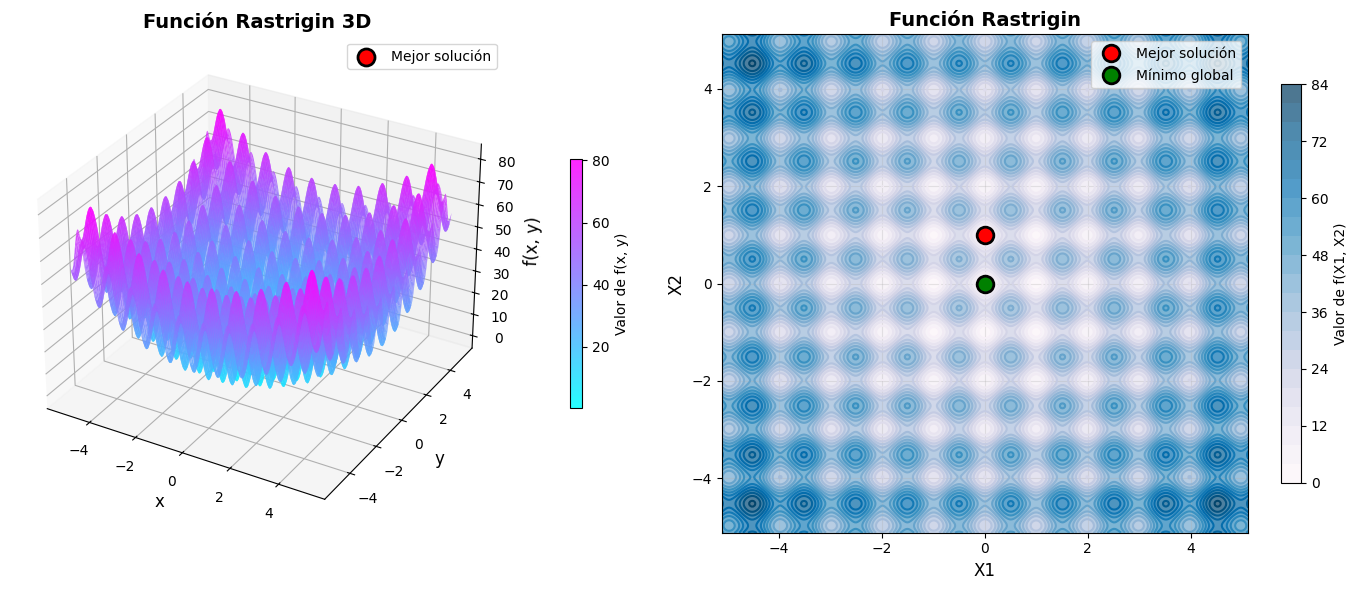

In [ ]:
# Graficas
x = np.linspace(Imin, Imax, 400)
y = np.linspace(Imin, Imax, 400)
X, Y = np.meshgrid(x, y)
Z = rastrigin([X, Y])
fig = plt.figure(figsize=(14, 6))
cmap_3d = 'cool'       
cmap_2d = 'PuBu'      
# ---------------------- GRÁFICA 3D  ----------------
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Función Rastrigin 3D', fontsize=14, fontweight='bold')
surface = ax1.plot_surface(X, Y, Z, cmap=cmap_3d, alpha=0.85, linewidth=0, antialiased=True, rstride=2, cstride=2)
# Punto de la mejor solución
ax1.scatter(mejor_solucion[0], mejor_solucion[1], rastrigin(mejor_solucion), color='red', s=150, label='Mejor solución', edgecolor='black', linewidth=2)

# Configuración de ejes
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_zlabel('f(x, y)', fontsize=12)
ax1.legend()
cbar = fig.colorbar(surface, ax=ax1, shrink=0.5, aspect=20, pad=0.1)
cbar.set_label('Valor de f(x, y)', fontsize=10)

# ---------------------- GRÁFICA 2D  ----------------
ax2 = fig.add_subplot(122)
ax2.set_title('Función Rastrigin 2D', fontsize=14, fontweight='bold')

# Contorno
contour = ax2.contour(X, Y, Z, 25, cmap=cmap_2d, linewidths=1.5)
contourf = ax2.contourf(X, Y, Z, 25, cmap=cmap_2d, alpha=0.7)
ax2.plot(mejor_solucion[0], mejor_solucion[1], 'ro', markersize=12, label='Mejor solución', markeredgecolor='black', markeredgewidth=2)
ax2.plot(0, 0, 'go', markersize=12, label='Mínimo global', markeredgecolor='black', markeredgewidth=2)

# Configuración de ejes
ax2.set_xlabel('X1', fontsize=12)
ax2.set_ylabel('X2', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Barra de colores para el contorno
cbar2 = fig.colorbar(contourf, ax=ax2, shrink=0.8)
cbar2.set_label('Valor de f(X1, X2)', fontsize=10)

plt.tight_layout()
plt.show()